# Stayin' Alive
### *An AI-Powered Tool for Optimal Restaurant and Bar Location Selection and Business Longevity*
42578 – Advanced Business Analytics, DTU, 2025 <br>
Group 21 - Crocs Validation<br>
Giulia Andreatta -s233128<br>
Gabriel Lanaro - s233541<br>
Alessia Saccardo - s212246<br>
Gabriele Turetta - s233124<br>

## Introduction 
### Objective
Opening a restaurant or a bar is a high-risk endeavor—many establishments close within their first few years. In Copenhagen, aspiring restaurateurs and investors often lack a data-driven approach when selecting a location. Moreover, understanding the reasons behind a restaurant’s success or failure remains a challenge.

This project aims to:

- Recommend optimal locations for new restaurants or bars using Survival Analysis.
- Visualize location suitability through an interactive heatmap enriched with predictive longevity scores, pedestrian peak hours, density of restaurants, pins of active and closed activities.

### Datasets

- **Company data scraped from the official CVR registry via [virk.dk](https://datacvr.virk.dk/soegeresultater?fritekst=d&sideIndex=0&size=10)**<br>
Includes business registration details, location, restaurant closures, branchekode.

- **Google Maps Scraped Data**<br>
Includes business location, rating, number of reviews, price range, tags.

- **Pedestrian Dataset from [OpenData.dk](https://www.opendata.dk/city-of-copenhagen/taelling_fodg#:~:text=Number%20of%20pedestrians%20counted%20on,19%20in%20both%20directions)**<br>
Provides foot traffic counts recorded at specific times and locations in Copenhagen.

- **People per Postal Code and Neighbordhood Dataset [Statbank.dk](https://www.statbank.dk/20021)**<br>
Provides the Population at the 1st of January 2025 by municipality, postal code, sex and age.

- **Area per postal code In Copenhagen [Postnumre-da.cybo](https://postnumre-da.cybo.com/danmark/k%C3%B8benhavn/)<br>**
Contains a lot of information about the postal codes but we took only the area of each one.

### ABA Topics Covered
- **Web Data Mining**
Scraping large-scale data from Google Maps and government databases to construct the datasets.

- **Survival Analysis**
Analyzing restaurant longevity using Kaplan-Meier and Cox Proportional Hazards models.

- **Recommended Systems**
Suggesting location options for new restaurants and bars based on existing market data and Branchekod.

- **AI in the Real World**
Delivering real value to stakeholders by supporting data-driven restaurant planning and resilience strategies via Survival Analysis outcome.



## 1st Step - Data Scraping from the official CVR registry

This script performs web scraping on the Danish company registry website (https://datacvr.virk.dk)
to extract company details for active business units in specified industry sectors (branchekoder).
It uses Selenium to navigate the search results, extract key information for each business unit,
and follow links to detailed company pages to obtain start and end dates.

The results are saved in a CSV file, and duplicate entries (based on P-number) are avoided by 
keeping track of already seen values. The script is designed to be resumed without duplicating 
previous entries.

Required: chromedriver installed and path correctly set.

Note: The output of the 1st and 2nd cells are already present in the data folder. If you want to run the scraping cells, take in mind that the run takes a very long time!


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
import time
import csv
import os

# === CONFIGURATION ===
driver_path = r"chromedriver/chromedriver.exe"
options = Options()
options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(service=Service(driver_path), options=options)


# the loop can be run for each branchekode separately, or all at once by uncommenting the lines below.
# In our project, the branchekodes were manually uncommented, to create a single csv file for each branchekode.
# This was done to avoid the script from running for too long, risking on IP bans or website crashes.
# The single csv files were then merged into a single csv file.
branchekodes = [
    # 561110,   # serving food in restaurants and cafes
    # 561190,   # includes the operation of restaurants, where the main emphasis is on takeaway with very limited table service.
    # 563010,   # includes serving beverages, possibly with some edibles, but where the main emphasis is on serving non-alcoholic beverages for immediate consumption on site.
    563020,  #  includes serving beverages, possibly with some edibles, but where the main emphasis is on serving alcoholic beverages for immediate consumption on the premises.
]

# Scraping Structure overview:
# - Main search results are loaded via URL with parameters: sideIndex (pagination), branchekode (industry), etc.
# - Each company entry is a 'div.row' within a 'div[data-cy="soegeresultater-tabel"]'.
# - Basic info (name, address, P-nummer, status, company type) is extracted directly from the search results.
# - For each company, the script follows the "Show More" link in a new browser tab to extract Start date (Startdato)
#   and End date (Ophørsdato), which appear in divs following label tags (either <strong> or <span>).
for branchekode in branchekodes:
    page = 0
    csv_file_path = f"data/scraped_companies_{branchekode}.csv"
    header = [
        "Name",
        "Address",
        "P-nummer",
        "Status",
        "Company Type",
        "Startdate",
        "Enddate",
    ]
    pnummer_seen = set()

    # Load existing P-numbers if the file already exists to avoid duplicates
    file_exists = os.path.exists(csv_file_path)
    if file_exists:
        with open(csv_file_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for row in reader:
                pnummer_seen.add(row["P-nummer"])
    else:
        # Create file and write header
        with open(csv_file_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=header)
            writer.writeheader()

    while True:
        url = f"https://datacvr.virk.dk/soegeresultater?sideIndex={page}&enhedstype=produktionsenhed&region=29190623&branchekode={branchekode}"
        print(f"Scraping page {page}")
        driver.get(url)
        time.sleep(2)

        # Get all company rows from the result table
        rows = driver.find_elements(
            By.CSS_SELECTOR, 'div[data-cy="soegeresultater-tabel"] > div.row'
        )

        if not rows:
            print("No data found. Stopping.")
            break

        # Process each company in the current page
        for row in rows:
            try:
                name = row.find_element(By.CSS_SELECTOR, "span.bold.value").text.strip()

                address_block = row.find_element(By.CSS_SELECTOR, "div.col-12.col-lg-4")
                address_lines = address_block.text.strip().split("\n")[-2:]
                address = ", ".join(address_lines)

                pnummer = row.find_element(
                    By.XPATH, './/div[div[text()="P-nummer:"]]/div[2]'
                ).text.strip()

                # Skip if already saved
                if pnummer in pnummer_seen:
                    continue
                pnummer_seen.add(pnummer)

                status = row.find_element(
                    By.XPATH, './/div[div[text()="Status:"]]/div[2]'
                ).text.strip()
                form = row.find_element(
                    By.XPATH, './/div[div[text()="Virksomhedsform:"]]/div[2]'
                ).text.strip()

                link_elem = row.find_element(
                    By.CSS_SELECTOR, 'div[data-cy="vis-mere"] a'
                )
                link = link_elem.get_attribute("href")

                # Open detail page in new tab
                driver.execute_script("window.open('');")
                driver.switch_to.window(driver.window_handles[1])
                driver.get(link)
                time.sleep(3)

                # Extract dates
                startdato = ""
                ophoersdato = ""

                # Extract start and end dates from the detail page
                try:
                    startdato_element = driver.find_element(
                        By.XPATH,
                        '//div[(strong[text()="Startdato"] or span[text()="Startdato"])]/following-sibling::div',
                    )
                    startdato = startdato_element.text.strip()
                except:
                    startdato = ""

                try:
                    ophoersdato_element = driver.find_element(
                        By.XPATH,
                        '//div[(strong[text()="Ophørsdato"] or span[text()="Ophørsdato"])]/following-sibling::div',
                    )
                    ophoersdato = ophoersdato_element.text.strip()
                except:
                    ophoersdato = ""

                # Close the detail tab and return to the main results tab
                driver.close()
                driver.switch_to.window(driver.window_handles[0])

                # Write to CSV
                with open(csv_file_path, "a", newline="", encoding="utf-8") as f:
                    writer = csv.DictWriter(f, fieldnames=header)
                    writer.writerow(
                        {
                            "Name": name,
                            "Address": address,
                            "P-nummer": pnummer,
                            "Status": status,
                            "Company Type": form,
                            "Startdate": startdato,
                            "Enddate": ophoersdato,
                        }
                    )

                print(f"{name} | {startdato} → {ophoersdato}")

            except Exception as e:
                print("Error during parsing:", e)
                continue

        page += 1
        time.sleep(1)

driver.quit()
print("Scraping finished.")

## 2nd Step - Geocoding Restaurant Addresses Using OpenStreetMap API

This script performs address geocoding using the OpenStreetMap (OSM) API via the geopy library. It takes as input a CSV file containing restaurant records with address fields but missing geographic coordinates (data/scraped_companies_combined_clean.csv). For each address, it attempts to retrieve the corresponding latitude and longitude, which are then saved in a new CSV file.

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import os

# === CONFIGURATION ===
input_file = "data/scraped_companies_combined_clean.csv"
output_file = "data/scraped_companies_combined_clean_with_coords.csv"

# === LOAD ORIGINAL DATA ===
df = pd.read_csv(input_file)


# Function to simplify the address before geocoding
def simplify_address(row):
    addr = str(row["Address"])
    addr = addr.split(",")[0].strip()  # only keep the part before the first comma
    return f"{addr}, Denmark"


# Add coordinate columns if they don't exist
if "latitude" not in df.columns:
    df["latitude"] = None
if "longitude" not in df.columns:
    df["longitude"] = None

# Load already geocoded addresses to avoid duplicates
already_done = set()
if os.path.exists(output_file):
    df_existing = pd.read_csv(output_file)
    already_done = set(df_existing["Address"].dropna().unique())
    print(f"Resuming from {len(already_done)} already completed addresses.")

# Filter rows that still need geocoding
df_to_process = df[~df["Address"].isin(already_done)].copy()
print(f"Addresses to geocode: {len(df_to_process)}")

# Initialize OpenStreetMap geocoder with delay to respect rate limits
geolocator = Nominatim(user_agent="stayin_alive_simple_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

# Progressive saving to CSV (append mode!!)
with open(output_file, "a", encoding="utf-8", newline="") as f_out:
    header_written = os.stat(output_file).st_size == 0
    for i, row in df_to_process.iterrows():
        full_address = simplify_address(row)
        try:
            location = geocode(full_address)
            if location:
                row["latitude"] = location.latitude
                row["longitude"] = location.longitude
                print(f"{full_address} -> ({location.latitude}, {location.longitude})")
            else:
                print(f"{full_address} -> not found")
        except Exception as e:
            print(f"Error on {full_address}: {e}")
            continue

        # Append row to output CSV
        pd.DataFrame([row]).to_csv(f_out, index=False, header=header_written)
        header_written = False

## 3rd Step - Scraping Restaurant Metadata from Google Maps with Selenium

This script performs web scraping from Google Maps using Selenium to enrich the dataset of restaurants obtained from steps 1-2 (data/scraped_companies_combined_clean_with_coords.csv). For each restaurant entry (name and address), the script:

1. Opens a Google Maps search page

2. Extracts the official listing title, star rating, number of reviews, price level, and associated category tags if present

3. Saves the collected data into a CSV file

4. The script supports resuming interrupted sessions by skipping entries that have already been saved to the output CSV file.

Required: chromedriver installed and path correctly set.

In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import csv
import os

# === CONFIGURATION ===
driver_path = r"chromedriver/chromedriver.exe"
options = Options()
options.add_argument("--window-size=1920,1080")
# options.add_argument("--headless")  # Uncomment to run without opening browser window

driver = webdriver.Chrome(service=Service(driver_path), options=options)

# === INPUT & OUTPUT PATHS ===
csv_input_path = r"data/scraped_companies_combined_clean_with_coords.csv"
csv_output_path = r"data/maps_data_scraped.csv"

# Load input data
df_input = pd.read_csv(csv_input_path)
restaurant_data = df_input.to_dict(orient="records")

# Load already saved entries (if output file exists)
saved_entries = set()
header = [
    "Input Name",
    "Input Address",
    "Title",
    "Rating",
    "Reviews",
    "Price Level",
    "Tags",
]

if os.path.exists(csv_output_path):
    with open(csv_output_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            key = (row["Input Name"], row["Input Address"])
            saved_entries.add(key)
else:
    with open(csv_output_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writeheader()

# === MAIN LOOP OVER RESTAURANTS ===
for entry in restaurant_data:
    name = entry["Name"]
    address = entry["Address"]
    key = (name, address)

    if key in saved_entries:
        continue

    try:
        print(f"Searching: {name} @ {address}")
        query = f"{name} {address}".replace(" ", "+")
        linkmaps = f"https://www.google.com/maps/search/{query}"
        print(f"URL: {linkmaps}")
        driver.get(linkmaps)
        time.sleep(2)

        try:
            title = driver.find_element(By.CSS_SELECTOR, "h1.DUwDvf").text
        except:
            title = ""

        try:
            rating = driver.find_element(
                By.CSS_SELECTOR, 'div.F7nice > span span[aria-hidden="true"]'
            ).text
        except:
            rating = ""

        try:
            reviews_elem = driver.find_element(
                By.CSS_SELECTOR, 'div.F7nice > span span[aria-label$="reviews"]'
            ).text
            reviews = reviews_elem.strip("()")
        except:
            reviews = ""

        try:
            price_level = driver.find_element(
                By.CSS_SELECTOR, "div.DfOCNb.fontBodyMedium > div"
            ).text.split("\n")[0]
        except:
            price_level = ""

        try:
            outer_divs = driver.find_elements(By.CSS_SELECTOR, "div.KNfEk.aUjao")
            tags = []
            for div in outer_divs:
                try:
                    tag = div.find_element(
                        By.CSS_SELECTOR, "div.tXNTee span.uEubGf.fontBodyMedium"
                    ).text
                    tags.append(tag)
                except:
                    continue
            tags = ", ".join(tags)
        except:
            tags = ""

        # Append to CSV immediately
        with open(csv_output_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=header)
            writer.writerow(
                {
                    "Input Name": name,
                    "Input Address": address,
                    "Title": title,
                    "Rating": rating,
                    "Reviews": reviews,
                    "Price Level": price_level,
                    "Tags": tags,
                }
            )

        print(f"Saved: {title}")

    except Exception as e:
        print("Error during scraping:", e)
        continue

driver.quit()
print("Scraping finished.")

## 4th Step – Cleaning and Preparing the Population by Postal Code Dataset


The original dataset included the following fields: **ID**, **Neighborhood**, **Total People**, **Total Men**, and **Total Women**. Preliminary data cleaning was performed primarily in Excel for convenience. The key steps were:

1. The **Neighborhood** column was split into two separate fields: **Postal Code** and **Neighborhood Name**, resulting in the file `cph_population_clean.csv`.
2. This cleaned dataset was merged with a postal code area reference table to enable the calculation of population density per postal code.
3. Population and restaurant densities were calculated, producing the final dataset `population_df.csv`.

In [11]:
import pandas as pd
import glob
import os
import re

# Step 1: Load cleaned population dataset
population_df = pd.read_csv(
    "data/cph_population_clean.csv",
    encoding="ISO-8859-1",
)

# Step 2: Collect all company data CSVs from the specified folder
# These files follow a naming convention like scraped_companies_<code>_active.csv
file_paths = glob.glob("data/Temp/scraped_companies_*.csv")

all_dfs = []

# Step 3: Loop through each company CSV file
for path in file_paths:
    filename = os.path.basename(path)

    # Extract the company identifier code from the filename
    try:
        code = filename.split("_")[2]
    except IndexError:
        code = "000000"  # Use fallback code if filename is not in expected format

    # Determine if the file refers to active companies
    is_active = filename.lower().endswith("active.csv")

    # Load the current CSV file
    df = pd.read_csv(path)

    # Add identifier and status columns to the DataFrame
    df["code"] = code
    df["active"] = is_active

    # Store in the list for later concatenation
    all_dfs.append(df)

# Step 4: Combine all company DataFrames into one
merged_df = pd.concat(all_dfs, ignore_index=True)

# Optional: Save merged file (currently commented out)
# merged_df.to_csv("merged_companies.csv", index=False)

print("Merge completed. File saved as merged_companies.csv")


# Step 5: Extract the postal code from the Address column using regex
def extract_postal_code(address):
    try:
        # Look for a pattern like ", 2100" where 2100 is the postal code
        match = re.search(r",\s*(\d{4})", address)
        return match.group(1) if match else None
    except:
        return None


# Apply the postal code extraction function
merged_df["postal_code"] = merged_df["Address"].apply(extract_postal_code)

# Drop columns that are not needed for the analysis
merged_df = merged_df.drop(columns=["Status"])
merged_df = merged_df.drop(columns=["Company Type"])

# Standardize column names and formats for merging
population_df = population_df.rename(columns={"neighborhood_id": "neighborhood_code"})
population_df = population_df.replace("-", 0)  # Replace dashes with 0 (if any)

# Ensure postal codes are strings to prevent merge issues
population_df["postal_code"] = population_df["postal_code"].astype(str)
population_df["postal_code_m2"] = population_df["postal_code_m2"].astype(int)
merged_df["postal_code"] = merged_df["postal_code"].astype(str)

# Step 6: Compute population density (people per km²)
population_df["population_density_km2"] = population_df["Total"] / (
    population_df["postal_code_m2"] / 1_000_000
)

# Step 7: Count how many restaurants (companies) exist per postal code
restaurant_counts = (
    merged_df.groupby("postal_code").size().reset_index(name="restaurant_count")
)

# Step 8: Merge restaurant counts into the population DataFrame
population_df = population_df.merge(restaurant_counts, on="postal_code", how="left")

# Fill any missing values (postal codes with 0 restaurants) with 0
population_df["restaurant_count"] = (
    population_df["restaurant_count"].fillna(0).astype(int)
)

# Step 9: Save final dataset with population and restaurant density info
population_df.to_csv("data/population_df.csv", index=False)

# Print a sample of the final DataFrame
print(population_df.head())

Merge completed. File saved as merged_companies.csv
   neighborhood_code neighborhood_name postal_code  postal_area  \
0                101         København        1050  København K   
1                101         København        1051  København K   
2                101         København        1052  København K   
3                101         København        1053  København K   
4                101         København        1054  København K   

   postal_code_m2  Total  Men  Women  population_density_km2  restaurant_count  
0           39053     20   10     10              512.124549                16  
1           55643    399  191    208             7170.713297                28  
2            6563    421  204    217            64147.493524                 2  
3            2434    404  181    223           165981.922761                 2  
4            4953    392  201    191            79143.953160                 1  


## 5th Step - 1st Heatmap, an interactive Spatial Visualization of Restaurants/Bars and Pedestrian Traffic in Copenhagen

This script generates an interactive Folium heatmap that visualizes restaurant/bar locations and pedestrian traffic in Copenhagen. It combines multiple layers of spatial data to support exploratory analysis for business location decisions. 
This initial heatmap with multiple layers serves as a visual foundation for later overlaying the survival analysis scores as a new layer in the heatmap. By combining all the layers, it will be possible fx to compare areas of high restaurant density and high pedestrian density with predicted survival outcomes, helping to identify not only where restaurants are concentrated, but also where they are most likely to succeed over time.

This first heatmap was obtained by combining the restaurants/bars dataset obtained in the first 2 steps (data/scraped_companies_combined_clean_with_coords.csv) and the Pedestrian Dataset downloaed from OpenData.dk (data/foot_traffic.csv)

Code key functionalities:
- Restaurant Heatmap: Shows the density of restaurant locations.
- Longevity Heatmap: Visualizes how long restaurants have stayed open, based on registration and closure dates.
- Status Markers: Differentiates between currently active and closed restaurants with green and red markers.
- Branchekode Filter: Allows filtering restaurants by industry classification code (branchekode).
- Pedestrian Traffic Heatmap: Displays average daily foot traffic (7 AM–7 PM) from official measurements.
- Peak Hour Traffic Circles: Highlights high-density areas during peak foot traffic (7 AM–7 PM) using proportional red circles.

The result is an interactive map saved as an HTML file, enabling users to toggle layers, explore patterns, and identify high-potential zones for business development.

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load restaurant dataset with coordinates
restaurants_df = pd.read_csv("data/scraped_companies_combined_clean_with_coords.csv")
restaurants_df = restaurants_df.dropna(subset=["latitude", "longitude"])

# Load pedestrian traffic dataset with coordinates
traffic_df = pd.read_csv("data/foot_trafic.csv")
traffic_df = traffic_df.dropna(subset=["lat", "lon"])

# Preprocessing longevity
restaurants_df["startdate"] = pd.to_datetime(
    restaurants_df["startdate"], errors="coerce"
)
restaurants_df["enddate"] = pd.to_datetime(restaurants_df["enddate"], errors="coerce")
restaurants_df["enddate_filled"] = restaurants_df["enddate"].fillna(
    pd.Timestamp.today()
)
restaurants_df["longevity_days"] = (
    restaurants_df["enddate_filled"] - restaurants_df["startdate"]
).dt.days

# Initialize the map centered on Copenhagen
map_ = folium.Map(location=[55.6761, 12.5683], zoom_start=13)

# --- HEATMAP: Restaurants ---
heat_points = restaurants_df[["latitude", "longitude"]].values.tolist()
heatmap_layer = folium.FeatureGroup(name="Restaurants Heatmap")
HeatMap(heat_points, radius=10, blur=15).add_to(heatmap_layer)
heatmap_layer.add_to(map_)

# --- HEATMAP: Longevity ---
longevity_points = (
    restaurants_df[["latitude", "longitude", "longevity_days"]].dropna().values.tolist()
)
longevity_layer = folium.FeatureGroup(name="Restaurants Longevity Heatmap", show=False)
HeatMap(longevity_points, radius=15, blur=25, max_zoom=14).add_to(longevity_layer)
longevity_layer.add_to(map_)

# --- MARKERS: Active / Closed Restaurants ---
active_layer = folium.FeatureGroup(name="Active Restaurants", show=False)
closed_layer = folium.FeatureGroup(name="Closed Restaurants", show=False)

for _, row in restaurants_df.iterrows():
    popup = folium.Popup(
        f"<b>{row.get('name', 'N/A')}</b><br>"
        f"Business Code: {row.get('branchekode', 'N/A')}<br>"
        f"Status: {row.get('status', 'N/A')}<br>"
        f"Opening Date: {row.get('startdate', 'N/A')}<br>"
        f"Postal Code: {row.get('zip', 'N/A')}",
        max_width=300,
    )
    marker = folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=popup,
        icon=folium.Icon(color="green" if row.get("active", False) else "red"),
    )
    if row.get("active", False):
        marker.add_to(active_layer)
    else:
        marker.add_to(closed_layer)

active_layer.add_to(map_)
closed_layer.add_to(map_)

# --- FILTER: Branchekode ---
branche_layer_dict = {}
for branche in restaurants_df["branchekode"].dropna().unique():
    layer = folium.FeatureGroup(name=f"Branchekode: {branche}", show=False)
    for _, row in restaurants_df[restaurants_df["branchekode"] == branche].iterrows():
        popup = folium.Popup(
            f"<b>{row.get('name', 'N/A')}</b><br>"
            f"Branchekode: {row.get('branchekode', 'N/A')}<br>"
            f"Status: {row.get('status', 'N/A')}<br>"
            f"Startdate: {row.get('startdate', 'N/A')}<br>"
            f"ZIP: {row.get('zip', 'N/A')}",
            max_width=300,
        )
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=4,
            color="blue",
            fill=True,
            fill_opacity=0.6,
            popup=popup,
        ).add_to(layer)
    layer.add_to(map_)

# --- PEDESTRIAN TRAFFIC: HEATMAP aadt_fod_7_19 ---
heat_traffic_points = (
    traffic_df[["lat", "lon", "aadt_fod_7_19"]].dropna().values.tolist()
)
heatmap_ped_layer = folium.FeatureGroup(name="Pedestrian Heatmap (7-19)")
HeatMap(heat_traffic_points, radius=15, blur=25, max_zoom=14).add_to(heatmap_ped_layer)
heatmap_ped_layer.add_to(map_)

# --- PEDESTRIAN TRAFFIC: CIRCLE LAYER hvdt_fod_7_19 ---
circle_layer = folium.FeatureGroup(name="Pedestrian Peak Hour 7-19", show=False)
for _, row in traffic_df.iterrows():
    value = row.get("hvdt_fod_7_19")
    if pd.notna(value):
        radius = value / 500  # scaling factor
        popup = folium.Popup(
            f"<b>{row.get('vejnavn', '')}</b><br>"
            f"Peak Hour 7-19: {int(value)}<br>"
            f"Description: {row.get('beskrivelse', '')}<br>"
            f"Date: {row.get('taelle_dato', '')}",
            max_width=300,
        )
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=radius,
            color="red",
            fill=True,
            fill_opacity=0.5,
            popup=popup,
        ).add_to(circle_layer)
circle_layer.add_to(map_)

# Add layer control to enable toggling layers
folium.LayerControl(collapsed=False).add_to(map_)

# Save the final map
map_.save("output/interactive_map_with_filtered_traffic.html")

The final aim of this project is to add a new layer to the existing heatmap that visualizes the results of the survival analysis. To perform the analysis and produce an output that could be displayed as a heatmap, it has been created a dataset in which each row corresponds to a unique geographic coordinate. The following sections describe the construction of the dataset used for the survival analysis.

## 6th Step - Expanding the Pedestrian Traffic Dataset to the entire Copenhagen municipality 

This script expands the pedestrian traffic dataset to cover the entire Copenhagen municipality. The original dataset (data/foot_trafic.csv) contains point-based pedestrian counts collected at specific locations, including fields such as `aadt_fod_7_19` (average daily traffic between 07:00–19:00) and `hvdt_fod_7_19` (peak traffic during the same period). Only these two fields were used in this step. 

To generalize the data spatially, the script first generates a regular 200-meter grid across the municipality and then clips it to the official boundary using Copenhagen's GeoJSON shapefile. Each grid point is then assigned average daily and peak pedestrian counts using inverse-distance weighting (IDW), a method that computes weighted averages of nearby observations with weights proportional to \(1/d^3\). 

The result is a new dataset (data/expanded_foot_trafic.csv) with over 7 000 grid points, each spaced 200 meters apart, containing estimated values of average and peak foot traffic.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Load and clean pedestrian counts
ped = pd.read_csv("data/foot_trafic.csv", parse_dates=["taelle_dato"])
ped["longitude"] = ped["wkb_geometry"].str.extract(r"POINT \(([^ ]+)")[0].astype(float)
ped["latitude"] = (
    ped["wkb_geometry"].str.extract(r"POINT \([^ ]+ ([^ ]+)\)")[0].astype(float)
)
ped = ped.dropna(subset=["latitude", "longitude"])
ped["aadt"] = pd.to_numeric(ped["aadt_fod_7_19"], errors="coerce")
ped["hvdt"] = pd.to_numeric(ped["hvdt_fod_7_19"], errors="coerce")
ped = ped.dropna(subset=["aadt", "hvdt"])

# Project to metric CRS for distance calculations
ped_gdf = gpd.GeoDataFrame(
    ped[["aadt", "hvdt", "longitude", "latitude"]],
    geometry=gpd.points_from_xy(ped.longitude, ped.latitude),
    crs="EPSG:4326",
).to_crs(epsg=3857)

print(f"Original pedestrian points: {len(ped_gdf)}")

# Build 200 m grid over Copenhagen
munis = gpd.read_file(
    "https://raw.githubusercontent.com/"
    "magnuslarsen/geoJSON-Danish-municipalities/"
    "master/municipalities/municipalities.geojson"
).to_crs(epsg=3857)
cph_union = munis[munis["label_dk"] == "København"].unary_union
spacing = 200
minx, miny, maxx, maxy = cph_union.bounds
xs = np.arange(minx, maxx + spacing, spacing)
ys = np.arange(miny, maxy + spacing, spacing)

grid = (
    gpd.GeoDataFrame(geometry=[Point(x, y) for x in xs for y in ys], crs="EPSG:3857")
    .loc[lambda df: df.within(cph_union)]
    .reset_index(drop=True)
)

print(f"Grid points after clipping: {len(grid)}")


# IDW interpolation function
def idw(point, xs, ys, values, power=3):
    d = np.hypot(xs - point.x, ys - point.y)
    w = 1.0 / (d**power + 1e-6)
    return (w * values).sum() / w.sum()


# Prepare arrays for interpolation
xs_pts = ped_gdf.geometry.x.values
ys_pts = ped_gdf.geometry.y.values
aadt_vals = ped_gdf["aadt"].values
hvdt_vals = ped_gdf["hvdt"].values

# Compute interpolated traffic counts
grid["aadt_fod_7_19"] = grid.geometry.apply(lambda p: idw(p, xs_pts, ys_pts, aadt_vals))
grid["hvdt_fod_7_19"] = grid.geometry.apply(lambda p: idw(p, xs_pts, ys_pts, hvdt_vals))

# Reproject to lat/lon and save
out = grid.to_crs(epsg=4326)
out["latitude"] = out.geometry.y
out["longitude"] = out.geometry.x
out[["latitude", "longitude", "aadt_fod_7_19", "hvdt_fod_7_19"]].to_csv(
    "data/expanded_foot_trafic.csv", index=False
)

print("Saved interpolated grid.")

Original pedestrian points: 403


/tmp/ipykernel_8026/1067146639.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cph_union = munis[munis["label_dk"] == "København"].unary_union


Grid points after clipping: 7062
Saved interpolated grid.


## 7th Step - Merge Pedestrian Traffic with Postal Area Demographics

This script takes three inputs:
- the DAWA GeoJSON of Danish postal-code areas, containing the polygon boundaries for each `postal_code`  
- a CSV of population statistics by postal code (data/population_df.csv), containing `neighborhood_code`, `neighborhood_name`, `postal_code`, `postal_area`, `postal_code_m2`, `Total`, `Men`, `Women`, `population_density_km2`
- the interpolated pedestrian traffic CSV (data/expanded_foot_trafic.csv) from the previous step, containing `latitude`, `longitude`, `aadt_fod_7_19`, and `hvdt_fod_7_19`  

It combines them into one clean output. First, it computes the geometric centroid of each postal-code polygon and merges these centroids with the population figures by matching on `postal_code`. Next for each point it checks which postal polygon contains it. Any points that fall outside all postal areas or lack full population data are removed. The result is a single CSV (data/pedestrian_with_zip_stats.csv) where each row gives a point’s latitude, longitude, interpolated pedestrian counts, its `postal_code`, and the linked demographic attributes.  


In [2]:
import geopandas as gpd
import pandas as pd

# Load postal areas and compute centroids
postal_gdf = gpd.read_file("https://dawa.aws.dk/postnumre?format=geojson").to_crs(
    epsg=4326
)
postal_gdf["zip_centroid"] = postal_gdf.geometry.centroid
postal_gdf["zip_lon"] = postal_gdf.zip_centroid.x
postal_gdf["zip_lat"] = postal_gdf.zip_centroid.y
postal_gdf = postal_gdf.rename(columns={"nr": "postal_code"})[
    ["postal_code", "zip_lat", "zip_lon", "geometry"]
]

# Load population data and merge
pop = pd.read_csv("data/population_df.csv", dtype={"postal_code": str})
pop["postal_code"] = pop["postal_code"].str.zfill(4)
postal_with_pop = postal_gdf.merge(pop, on="postal_code", how="left")

# Load interpolated pedestrian traffic and convert to GeoDataFrame
ped = pd.read_csv("data/expanded_foot_trafic.csv")
ped_gdf = gpd.GeoDataFrame(
    ped, geometry=gpd.points_from_xy(ped.longitude, ped.latitude), crs="EPSG:4326"
)

# Spatial join pedestrians to postal areas
joined = gpd.sjoin(ped_gdf, postal_with_pop, how="left", predicate="within")

# Remove rows where population stats are missing
joined = joined.dropna(subset=["Total", "Men", "Women", "population_density_km2"])

# Select final columns and save
joined[
    [
        "latitude",
        "longitude",
        "aadt_fod_7_19",
        "hvdt_fod_7_19",
        "postal_code",
        "Total",
        "Men",
        "Women",
        "population_density_km2",
    ]
].to_csv("data/pedestrian_with_zip_stats.csv", index=False)

/tmp/ipykernel_8026/392023623.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postal_gdf["zip_centroid"] = postal_gdf.geometry.centroid


## 8th Step - Modifying End dates of restaurants
As the info of the closing dates of the restaurants were available only for 2025, we decided to generate some mock data for having some closing dates also the years before.

### First of all we need to clean the maps Dataset
This code loads a dataset of Google Maps business reviews and performs several cleaning and transformation steps to prepare it for analysis. 

First, it standardizes the `Price Level` field by mapping price descriptions to numeric values and flags missing mappings.
It then ensures that the `Rating` column is numeric and fills missing values with a default of 3.5. To improve accuracy,original ratings are remerged and used to restore missing or incorrect values. 
Similarly, the `Reviews` column is converted to numeric, with missing values filled with 5. The cleaned and enriched dataset is saved to a new CSV file named `mapsReviews_ds_NoNull.csv`.








In [ ]:
import pandas as pd

# Load dataset
mapsReviews_ds = pd.read_csv("data/maps_data_scraped.csv")

# Price level mapping
price_mapping = {
    "1-100 kr a persona": 1,
    "1-200 kr a persona": 1,
    "100-200 kr a persona": 1,
    "100-300 kr a persona": 2,
    "200-300 kr a persona": 2,
    "200-400 kr a persona": 2,
    "300-400 kr a persona": 3,
    "300-500 kr a persona": 3,
    "400-500 kr a persona": 3,
    "400-600 kr a persona": 3,
    "500-600 kr a persona": 3,
    "600-700 kr a persona": 4,
    "Più di 1000 kr a persona": 5,
    "2000-4000 kr a persona": 5,
    "1-10 â\x82¬ a persona": 1,
    "30-40 â\x82¬ a persona": 2,
}
mapsReviews_ds["price_level_mapped"] = (
    mapsReviews_ds["Price Level"].map(price_mapping).fillna(2)
)
mapsReviews_ds["price_level_missing"] = (
    mapsReviews_ds["Price Level"].map(price_mapping).isna()
)

# Clean ratings
mapsReviews_ds["Rating"] = pd.to_numeric(
    mapsReviews_ds["Rating"], errors="coerce"
).fillna(3.5)
mapsReviews_ds["rating_missing"] = mapsReviews_ds["Rating"].isna()

# Restore from original ratings
original_ratings = pd.read_csv("data/maps_data_scraped.csv")[
    ["Input Name", "Rating"]
].dropna()
mapsReviews_ds = mapsReviews_ds.merge(
    original_ratings, on="Input Name", how="left", suffixes=("", "_original")
)

mapsReviews_ds["Rating"] = mapsReviews_ds["Rating_original"].combine_first(
    mapsReviews_ds["Rating"]
)
mapsReviews_ds.drop(columns=["Rating_original"], inplace=True)


# Clean reviews
mapsReviews_ds["Reviews"] = pd.to_numeric(
    mapsReviews_ds["Reviews"], errors="coerce"
).fillna(5)

# Save result
mapsReviews_ds.to_csv("data/mapsReviews_ds_NoNull.csv", index=False)

### Now we need to merge all the datasets into one
This section prepares a merged dataset by fuzzy-matching restaurant names from two sources: a base dataset and a reviews dataset. 

It then enriches the data by attaching population statistics and estimating foot traffic. Postal codes are geocoded to obtain coordinates, which are used to find the nearest foot traffic measurement station. The result is a comprehensive dataset containing reviews, population density, and foot traffic for each restaurant. This will be used to calculate the updated End Date of restaurants.

In [ ]:
from rapidfuzz import process
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import time

restaurants_ds = pd.read_csv("data/restaurants_df.csv")
population_ds = pd.read_csv("data/population_df.csv")
footTraffic_ds = pd.read_csv("data/expanded_foot_trafic.csv")


def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).lower().strip().replace("  ", " ")


# Puliamo nei due dataset
restaurants_ds["Name_clean"] = restaurants_ds["Name"].apply(clean_text)
restaurants_ds["Address_clean"] = restaurants_ds["Address"].apply(clean_text)

mapsReviews_ds["Input Name_clean"] = mapsReviews_ds["Input Name"].apply(clean_text)
mapsReviews_ds["Input Address_clean"] = mapsReviews_ds["Input Address"].apply(
    clean_text
)


# Creiamo dizionario dei nomi delle review
review_names = mapsReviews_ds["Input Name_clean"].tolist()


def fuzzy_match(name):
    match = process.extractOne(
        name, review_names, score_cutoff=80
    )  # solo se >80% di similarità
    if match:
        return match[0]
    return None


# Applichiamo fuzzy matching
restaurants_ds["matched_name"] = restaurants_ds["Name_clean"].apply(fuzzy_match)

# Poi merge
merged_df = restaurants_ds.merge(
    mapsReviews_ds,
    how="left",
    left_on="matched_name",
    right_on="Input Name_clean",
    suffixes=("", "_review"),
)


# Quanti ristoranti hanno trovato Rating (cioè matchato?)
matched = merged_df["Rating"].notna().sum()

# Quanti ristoranti NON hanno trovato Rating?
unmatched = merged_df["Rating"].isna().sum()

# Quanti ristoranti totali?
total = len(merged_df)

# Percentuali
matched_pct = (matched / total) * 100
unmatched_pct = (unmatched / total) * 100

# Stampa il risultato
print(f"Matched: {matched} ({matched_pct:.2f}%)")
print(f"Unmatched: {unmatched} ({unmatched_pct:.2f}%)")

merged_df = merged_df.merge(
    population_ds[
        ["postal_code", "Total", "population_density_km2", "restaurant_count"]
    ],
    how="left",
    on="postal_code",
    suffixes=("", "_population"),
)

geolocator = Nominatim(user_agent="foot_traffic_matcher")


# Funzione che geocodifica un postal_code
def get_coordinates(postal_code):
    try:
        location = geolocator.geocode(f"{postal_code} Copenhagen Denmark")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None


# Creiamo una nuova tabella con CAP unici
postal_code_unique = merged_df["postal_code"].dropna().unique()

# Geocodifica di tutti i CAP
postal_code_coords = []
for code in postal_code_unique:
    lat, lon = get_coordinates(code)
    postal_code_coords.append((code, lat, lon))
    time.sleep(1)  # importantissimo per non farsi bloccare

postal_coords_df = pd.DataFrame(
    postal_code_coords, columns=["postal_code", "latitude", "longitude"]
)


# Funzione per trovare il foot traffic della stazione più vicina
def find_nearest_traffic(lat, lon, stations_df):
    distances = stations_df.apply(
        lambda row: geodesic((lat, lon), (row["latitude"], row["longitude"])).meters,
        axis=1,
    )
    nearest_idx = distances.idxmin()
    return stations_df.loc[
        nearest_idx, "aadt_fod_7_19"
    ]  # puoi cambiare con 'hvdt_fod_7_19' se vuoi picco


# Applichiamo a tutti i CAP
postal_coords_df["foot_traffic"] = postal_coords_df.apply(
    lambda row: find_nearest_traffic(row["latitude"], row["longitude"], footTraffic_ds),
    axis=1,
)

# Merge su postal_code
merged_df = merged_df.merge(
    postal_coords_df[["postal_code", "latitude", "longitude", "foot_traffic"]],
    how="left",
    on="postal_code",
)

Matched: 5761 (100.00%)
Unmatched: 0 (0.00%)


### With the final merged dataset we can compute the new closing Date

In this part of the project, we simulate the expected closure dates of businesses based on factors such as rating, reviews, price level, foot traffic, and population density. A risk score is computed for each business and used to probabilistically determine how many years it remains open. Businesses predicted to close have their simulated end dates generated accordingly. The dataset is then updated to reflect closure status, duration of activity, and cleaned of inconsistencies.

Following the simulation, we prepare the final dataset for export by selecting relevant columns, applying fuzzy matching to merge business metadata from an external source, and renaming fields for clarity. The result is a structured dataset ready for analysis, containing both observed and simulated information about business performance and survival.





In [ ]:
import numpy as np
import pandas as pd


# Function to simulate closure time and compute risk based on business features
def simulate_closure_date(row):
    # Parse rating safely
    try:
        rating = float(row["Rating"])
    except:
        rating = 3.5

    risk = 0

    # Rating contribution
    if rating < 3.5:
        risk += 0.4
    elif rating > 4.2:
        risk += 0.1
    else:
        risk += 0.25

    # Extreme price levels
    if row["price_level_mapped"] in [1, 5]:
        risk += 0.15

    # Low review count
    try:
        reviews = float(row["Reviews"])
    except:
        reviews = 5
    if reviews < 10:
        risk += 0.1

    # Low foot traffic
    if pd.notna(row.get("foot_traffic")) and float(row["foot_traffic"]) < 3000:
        risk += 0.15

    # Low population density
    if (
        pd.notna(row.get("population_density_km2"))
        and float(row["population_density_km2"]) < 5000
    ):
        risk += 0.1

    risk = min(risk, 1.0)

    # Use risk score to influence closure time simulation
    r = np.random.rand()
    if r < 0.6 + 0.3 * risk:
        closure_years = np.random.randint(2, 8)
    elif r < 0.9 + 0.08 * (1 - risk):
        closure_years = np.random.randint(8, 16)
    else:
        closure_years = min(np.random.geometric(0.02), 30)

    return pd.Series({"closure_years": closure_years, "closure_risk": risk})


# Apply the closure time and risk computation
merged_df[["closure_years", "closure_risk"]] = merged_df.apply(
    simulate_closure_date, axis=1
)

# Set random seed for reproducibility
np.random.seed(42)

# Simulate a random value only for active businesses
mask_open = merged_df["active"] == True
merged_df.loc[mask_open, "random_val"] = np.random.rand(mask_open.sum())

# Determine which active businesses will close
merged_df["closure_simulated"] = False
merged_df.loc[mask_open, "closure_simulated"] = (
    merged_df.loc[mask_open, "random_val"] < merged_df.loc[mask_open, "closure_risk"]
)

# Convert Startdate to datetime safely
merged_df["Startdate"] = pd.to_datetime(merged_df["Startdate"], errors="coerce")

# Today's date
today = pd.to_datetime("today")

# Simulate end dates for newly closed businesses
mask_newly_closed = mask_open & merged_df["closure_simulated"]
merged_df.loc[mask_newly_closed, "Simulated_EndDate"] = merged_df.loc[
    mask_newly_closed, "Startdate"
] + pd.to_timedelta(
    np.random.randint(2 * 365, 7 * 365, size=mask_newly_closed.sum()), unit="D"
)

# Mark businesses as inactive if they closed
merged_df.loc[mask_newly_closed, "active"] = False

# Ensure Simulated_EndDate is in datetime format
merged_df["Simulated_EndDate"] = pd.to_datetime(merged_df["Simulated_EndDate"])

# Compute survival duration in days
merged_df["duration_days"] = (
    merged_df["Simulated_EndDate"].fillna(today) - merged_df["Startdate"]
).dt.days

# Save the final dataset
# merged_df.to_csv("merged_restaurants_final.csv", index=False)

In [18]:
# Sicurezza: Simulated_EndDate è datetime
merged_df["Simulated_EndDate"] = pd.to_datetime(
    merged_df["Simulated_EndDate"], errors="coerce"
)

# Assicuriamoci Startdate sia datetime
merged_df["Startdate"] = pd.to_datetime(merged_df["Startdate"], errors="coerce")

# Se la chiusura è futura ➔ resettiamo
mask_future_closures = merged_df["Simulated_EndDate"] > today

# Mettiamo NaT dove la data è futura
merged_df.loc[mask_future_closures, "Simulated_EndDate"] = pd.NaT

# Aggiorniamo anche is_closed
merged_df["is_closed"] = merged_df["Simulated_EndDate"].notna().astype(int)

# Ricalcoliamo duration_days
merged_df["duration_days"] = (
    merged_df["Simulated_EndDate"].fillna(today) - merged_df["Startdate"]
).dt.days

# (Opzionale) duration in anni
merged_df["duration_years"] = merged_df["duration_days"] / 365

merged_df = merged_df.drop_duplicates("Name")

In [24]:
import pandas as pd
from rapidfuzz import process

# Load the scraped dataset
scraped_df = pd.read_csv("data/scraped_companies_combined_clean_with_coords.csv")

# Remove duplicate companies based on the name
scraped_df = scraped_df.drop_duplicates("name")

# Columns to keep from the merged dataset
columns_to_keep = [
    "Name",
    "Address",
    "Startdate",
    "Simulated_EndDate",
    "code",
    "postal_code",
    "Rating",
    "Reviews",
    "price_level_mapped",
    "duration_days",
]

# Select and filter only the desired columns
filtered_df = merged_df[columns_to_keep].copy()

# Clean names and addresses in both datasets
filtered_df["Name_clean"] = filtered_df["Name"].apply(clean_text)
filtered_df["Address_clean"] = filtered_df["Address"].apply(clean_text)
scraped_df["name_clean"] = scraped_df["name"].apply(clean_text)
scraped_df["address_clean"] = scraped_df["address"].apply(clean_text)

# Drop irrelevant column if present
scraped_df = scraped_df.drop(columns=["company type"], errors="ignore")

# Create matching keys for fuzzy matching
filtered_df["match_key"] = (
    filtered_df["Name_clean"] + " " + filtered_df["Address_clean"]
)
scraped_df["match_key"] = scraped_df["name_clean"] + " " + scraped_df["address_clean"]

# Create a list of keys from the scraped dataset
scraped_keys = scraped_df["match_key"].tolist()


# Fuzzy matching function
def fuzzy_match(key):
    match = process.extractOne(key, scraped_keys, score_cutoff=85)
    return match[0] if match else None


# Apply fuzzy matching to each restaurant
filtered_df["matched_key"] = filtered_df["match_key"].apply(fuzzy_match)

# Report number of matches found
matched = filtered_df["matched_key"].notna().sum()
total = len(filtered_df)
print(f"Matches found: {matched}/{total} ({matched / total:.1%})")

# Merge datasets on matched keys
merged_df = filtered_df.merge(
    scraped_df,
    how="left",
    left_on="matched_key",
    right_on="match_key",
    suffixes=("", "_scraped"),
)

# Drop unnecessary columns
columns_to_drop = [
    "name",
    "address",
    "p_nummer",
    "startdate",
    "enddate",
    "branchekode",
    "zip",
    "active",
    "match_key_scraped",
    "Name_clean",
    "Address_clean",
    "matched_key",
    "name_clean",
    "address_clean",
    "match_key",
]
mergedFinal_df = merged_df.drop(columns=columns_to_drop, errors="ignore")

# Rename columns for clarity
mergedFinal_df = mergedFinal_df.rename(
    columns={
        "Name": "Restaurant_Name",
        "Address": "Restaurant_Address",
        "Startdate": "Opening_Date",
        "Simulated_EndDate": "Closing_Date",
        "code": "Branchekod",
        "postal_code": "Postal_Code",
        "Rating": "Rating",
        "Reviews": "Number_of_Reviews",
        "price_level_mapped": "Price_Level",
        "duration_days": "Duration_in_Days",
        "status": "Status",
        "latitude": "Latitude",
        "longitude": "Longitude",
    }
)

# Remove rows with missing opening date
mergedFinal_df = mergedFinal_df.dropna(subset=["Opening_Date"])

# Save final dataset to CSV
mergedFinal_df.to_csv("data/mergedFinal_ds.csv", index=False)

Matches found: 4224/4224 (100.0%)


In [25]:
# Merge the two datasets using the fuzzy-matched key
merged_df = filtered_df.merge(
    scraped_df,
    how="left",
    left_on="matched_key",
    right_on="match_key",
    suffixes=("", "_scraped"),
)

# Columns to drop after merge (unneeded or redundant)
columns_to_drop = [
    "name",
    "address",
    "p_nummer",
    "startdate",
    "enddate",
    "branchekode",
    "zip",
    "active",
    "match_key_scraped",
    "Name_clean",
    "Address_clean",
    "matched_key",
    "name_clean",
    "address_clean",
    "match_key",
]

# Drop columns safely, ignore if not present
mergedFinal_df = merged_df.drop(columns=columns_to_drop, errors="ignore")

# Rename columns for clarity and consistency
mergedFinal_df = mergedFinal_df.rename(
    columns={
        "Name": "Restaurant_Name",
        "Address": "Restaurant_Address",
        "Startdate": "Opening_Date",
        "Simulated_EndDate": "Closing_Date",
        "code": "Branchekod",
        "postal_code": "Postal_Code",
        "Rating": "Rating",
        "Reviews": "Number_of_Reviews",
        "price_level_mapped": "Price_Level",
        "duration_days": "Duration_in_Days",
        "status": "Status",
        "latitude": "Latitude",
        "longitude": "Longitude",
    }
)

# Remove rows missing an opening date
mergedFinal_df = mergedFinal_df.dropna(subset=["Opening_Date"])

# Save the cleaned and formatted DataFrame to CSV
mergedFinal_df.to_csv("data/mergedFinal_ds.csv", index=False)

## 9th Step - Creating the Final Dataset for Survival Analysis by adding restaurant information

This script creates the final dataset used to perform the survival analysis. To build this dataset, two sources are merged:

- The dataset generated at step 7 (data/pedestrian_with_zip_stats.csv), which contains a 200-meter grid covering the Copenhagen municipality. Each point includes interpolated pedestrian traffic values and demographic data such as population density and gender breakdown.
- A dataset of restaurants (mergedFinal_ds.csv) that includes the following fields:
  - `Restaurant_Name`, `Restaurant_Address`: identification and location details  
  - `Opening_Date`, `Closing_Date`: used to calculate how long each restaurant has been in operation  
  - `Branchekod`: an industry code classifying the type of restaurant  
  - `Postal_Code`: used for linking with demographic data  
  - `Rating`, `Number_of_Reviews`, `Price_Level`: customer review and pricing information  
  - `Latitude`, `Longitude`: geographic coordinates of the restaurant  

The goal of the script is to assign to each coordinate in the grid the aggregated characteristics of restaurants located within a 200-meter radius. First, a circular buffer is created around each grid point, and restaurants that fall within these buffers are identified using a spatial join. For each grid point, the script computes several statistics: the total number of restaurants nearby, how many are still open or have closed, their average and median survival times (in days, months, and years), the number of openings and closures in the last three years, and the mean values of customer ratings, number of reviews, and price levels.

Additionally, the frequency of each restaurant type (based on `Branchekod`) is computed and added as separate columns. These aggregated values are merged back into the original grid, which is then reprojected to latitude and longitude.

The result is saved as (data/df_survival_analysis.csv).

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime

radius_m = 200

# Load grid with zip/pop and convert to metric CRS
grid = pd.read_csv("data/pedestrian_with_zip_stats.csv")
grid_gdf = gpd.GeoDataFrame(
    grid, geometry=gpd.points_from_xy(grid.longitude, grid.latitude), crs="EPSG:4326"
).to_crs(epsg=3857)

# Load and prepare restaurant data
rest = pd.read_csv(
    "data/mergedFinal_ds.csv",
    parse_dates=["Opening_Date", "Closing_Date"],
    dayfirst=True,
).rename(
    columns={
        "Opening_Date": "startdate",
        "Closing_Date": "enddate",
        "Price_Level": "price_level",
    }
)

# Clean and convert numeric columns
for col in ["Rating", "Number_of_Reviews", "price_level"]:
    rest[col] = (
        rest[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace("nan", pd.NA)
        .astype(float)
    )


rest_gdf = gpd.GeoDataFrame(
    rest, geometry=gpd.points_from_xy(rest.Longitude, rest.Latitude), crs="EPSG:4326"
).to_crs(epsg=3857)


# Compute survival time
today = pd.Timestamp(datetime.today())
rest_gdf["survival_days"] = (
    rest_gdf["enddate"].fillna(today) - rest_gdf["startdate"]
).dt.days

# Buffer grid points and spatially join restaurants
buffers = grid_gdf.copy()
buffers["geometry"] = buffers.geometry.buffer(radius_m)
joined = gpd.sjoin(
    rest_gdf, buffers[["geometry"]], how="inner", predicate="within"
).rename(columns={"index_right": "grid_index"})


# Aggregate restaurant stats per grid cell
def agg_stats(df):
    now3 = today - pd.DateOffset(years=3)
    sd = df["survival_days"]
    return pd.Series(
        {
            "num_restaurants_total": len(df),
            "num_restaurants_open": df["enddate"].isna().sum(),
            "num_restaurants_closed": df["enddate"].notna().sum(),
            "avg_survival_days": sd.mean(),
            "median_survival_days": sd.median(),
            "avg_survival_months": sd.mean() / 30.44,
            "avg_survival_years": sd.mean() / 365.25,
            "openings_last_3_years": (df["startdate"] >= now3).sum(),
            "closures_last_3_years": (df["enddate"] >= now3).sum(),
            "mean_rating": df["Rating"].mean(),
            "mean_reviews": df["Number_of_Reviews"].mean(),
            "mean_price_level": df["price_level"].mean(),
        }
    )


stats = joined.groupby("grid_index").apply(agg_stats)

# Pivot branch codes and join
code_counts = (
    joined.groupby(["grid_index", "Branchekod"])
    .size()
    .unstack(fill_value=0)
    .add_prefix("code_")
)
stats = stats.join(code_counts, how="left").fillna(0)

# Merge back onto grid, reproject, extract coords
result = grid_gdf.join(stats, how="left").fillna(0).to_crs(epsg=4326)
result["latitude"] = result.geometry.y
result["longitude"] = result.geometry.x

# Select final columns and save
base_cols = [
    "latitude",
    "longitude",
    "aadt_fod_7_19",
    "hvdt_fod_7_19",
    "postal_code",
    "Total",
    "Men",
    "Women",
    "population_density_km2",
    "num_restaurants_total",
    "num_restaurants_open",
    "num_restaurants_closed",
    "avg_survival_days",
    "median_survival_days",
    "avg_survival_months",
    "avg_survival_years",
    "openings_last_3_years",
    "closures_last_3_years",
    "mean_rating",
    "mean_reviews",
    "mean_price_level",
]
code_cols = [c for c in stats.columns if c.startswith("code_")]
final_df = result[base_cols + code_cols]

final_df.to_csv("data/df_survival_analysis.csv", index=False)
print("Saved df_survival_analysis.csv")

/tmp/ipykernel_8026/1748939963.py:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  rest = pd.read_csv(
/tmp/ipykernel_8026/1748939963.py:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  rest = pd.read_csv(


Saved df_survival_analysis.csv


The table below describes the columns included in the final dataset `df_survival_analysis.csv` where each row represents a 200-meter grid point and includes pedestrian traffic, demographic statistics, and aggregated information about nearby restaurants.  


| Column                     | Description                                                                                       |
|----------------------------|---------------------------------------------------------------------------------------------------|
| **latitude**               | Grid point latitude (decimal degrees, WGS84)                                                      |
| **longitude**              | Grid point longitude (decimal degrees, WGS84)                                                     |
| **aadt_fod_7_19**          | Interpolated average daily pedestrian volume (between 07:00–19:00)                                 |
| **hvdt_fod_7_19**          | Interpolated peak pedestrian volume (between 07:00–19:00)                                          |
| **postal_code**            | Danish postal code containing the grid point                                                      |
| **Total**                  | Total population in the postal area                                                               |
| **Men**                    | Male population in the postal area                                                                |
| **Women**                  | Female population in the postal area                                                              |
| **population_density_km2** | Population density (people per km²) in the postal area                                            |
| **num_restaurants_total**  | Total number of restaurants within 200 m of the grid point                                        |
| **num_restaurants_open**   | Number of those restaurants still open                                                            |
| **num_restaurants_closed** | Number of those restaurants that have closed                                                      |
| **avg_survival_days**      | Mean restaurant “survival” time (days between opening and closing or today)                       |
| **median_survival_days**   | Median restaurant “survival” time (days)                                                          |
| **avg_survival_months**    | Mean survival time converted to months (days/30.44)                                               |
| **avg_survival_years**     | Mean survival time converted to years (days/365.25)                                               |
| **openings_last_3_years**  | Count of restaurant openings in the past 3 years                                                  |
| **closures_last_3_years**  | Count of restaurant closures in the past 3 years                                                  |
| **mean_rating**            | Average customer rating of restaurants in the buffer                                              |
| **mean_reviews**           | Average number of reviews per restaurant in the buffer                                            |
| **mean_price_level**       | Average price-level indicator of restaurants in the buffer                                        |
| **code_<Branchekod>**      | Number of restaurants with branch code `<Branchekod>` within 200 m (one column per branch code)   |

## 10th Step - Survival Analysis

#### Definition of Survival Analysis for our Dataset **df_survival_analysis.csv**

An analysis of the average life span of restaurants located within a 200-metre radius of specific Copenhagen grid points is then carried out.
The structure of the dataset allow us to model and estimate the probability that a restaurant near a given point will remain open over time.


##### Variables Used in the Survival Model are diefined as follow:

- The **time** variable is defined as `avg_survival_days`, representing the average survival duration (in days) of restaurants located within 200 meters of each grid point.

- The **event** variable is derived as:
  
  ```python
  event = 1 if num_restaurants_closed > 0 else 0



In [150]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import seaborn as sns
from lifelines.statistics import proportional_hazard_test

In [ ]:
# Load the dataset
df = pd.read_csv("data/df_survival_analysis.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7025 entries, 0 to 7024
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   latitude                7025 non-null   float64
 1   longitude               7025 non-null   float64
 2   aadt_fod_7_19           7025 non-null   float64
 3   hvdt_fod_7_19           7025 non-null   float64
 4   postal_code             7025 non-null   int64  
 5   Total                   7025 non-null   float64
 6   Men                     7025 non-null   float64
 7   Women                   7025 non-null   float64
 8   population_density_km2  7025 non-null   float64
 9   num_restaurants_total   7025 non-null   float64
 10  num_restaurants_open    7025 non-null   float64
 11  num_restaurants_closed  7025 non-null   float64
 12  avg_survival_days       7025 non-null   float64
 13  median_survival_days    7025 non-null   float64
 14  avg_survival_months     7025 non-null   

#### Creation of the time & event columns 
`duration` = how long restaurants near this point have survived on average

`event` = whether any restaurant has closed (event happened)

In [ ]:
# Duration
df["duration"] = df["avg_survival_days"]
df = df[df["duration"].notnull() & (df["duration"] >= 0)]

# Event
df["event"] = df["num_restaurants_closed"].apply(lambda x: 1 if x > 0 else 0)

# Remove rows where the Event or Duration is missing
df = df.dropna(subset=["duration", "event"])

#### Survival Analysis with Kaplan-Meier 
1) KM model on all grid points 

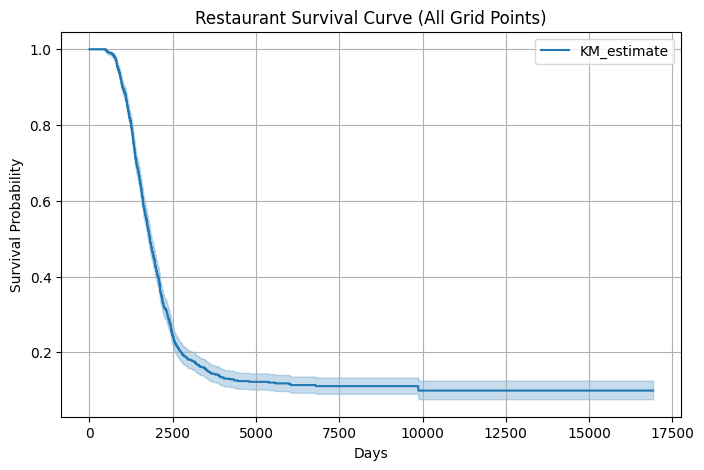

In [ ]:
# Kaplan-Meier model
kmf = KaplanMeierFitter()
# Fit
kmf.fit(durations=df["duration"], event_observed=df["event"])

# Plot
plt.figure(figsize=(8, 5))
kmf.plot_survival_function()
plt.title("Restaurant Survival Curve (All Grid Points)")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

2) KM model by:
    - Presence of Restaurant Code Type
    - Dominant Restaurant Code Type (normalized to avoids bias due to overlapping categories or unequal counts.)

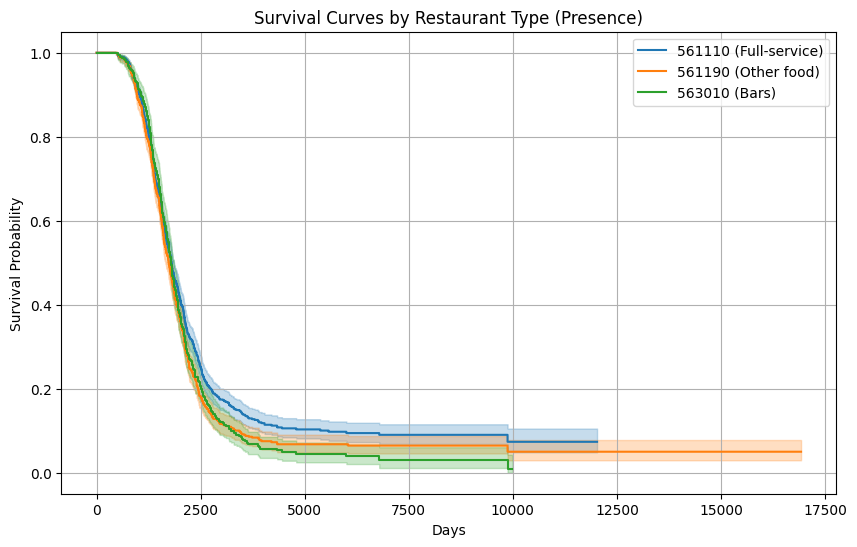

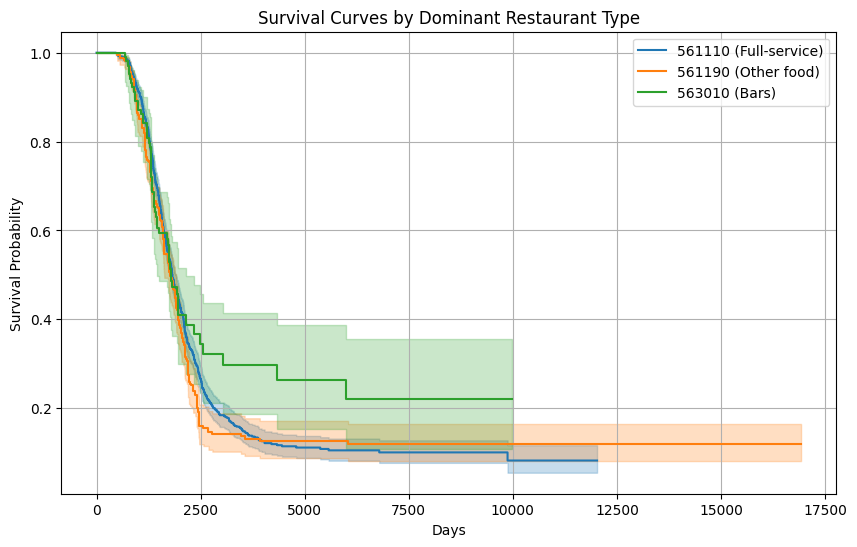

In [ ]:
# Calculate proportion for each restaurant type per grid point
df["prop_561110"] = df["code_561110"] / df["num_restaurants_total"]
df["prop_561190"] = df["code_561190"] / df["num_restaurants_total"]
df["prop_563010"] = df["code_563010"] / df["num_restaurants_total"]

# Create labels for presence of each code
df["has_561110"] = df["code_561110"] > 0
df["has_561190"] = df["code_561190"] > 0
df["has_563010"] = df["code_563010"] > 0


# Create dominant type column based on proportions
def get_dominant_type(row):
    proportions = {
        "561110": row["prop_561110"],
        "561190": row["prop_561190"],
        "563010": row["prop_563010"],
    }
    return (
        max(proportions, key=proportions.get)
        if row["num_restaurants_total"] > 0
        else np.nan
    )


df["dominant_code"] = df.apply(get_dominant_type, axis=1)


# ---- Plot 1: KM curves for presence of restaurant types
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

labels = ["561110 (Full-service)", "561190 (Other food)", "563010 (Bars)"]

for code_col, label in zip(["has_561110", "has_561190", "has_563010"], labels):
    mask = df[code_col]
    kmf.fit(
        durations=df[mask]["duration"], event_observed=df[mask]["event"], label=label
    )
    kmf.plot_survival_function()

plt.title("Survival Curves by Restaurant Type (Presence)")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


# ---- Plot 2: KM curves for dominant restaurant type based on proportion
plt.figure(figsize=(10, 6))
for code, label in zip(["561110", "561190", "563010"], labels):
    mask = df["dominant_code"] == code
    kmf.fit(
        durations=df[mask]["duration"], event_observed=df[mask]["event"], label=label
    )
    kmf.plot_survival_function()

plt.title("Survival Curves by Dominant Restaurant Type")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


# dummies
df = pd.get_dummies(df, columns=["dominant_code"], drop_first=True)

In the previous steps of the code we have:
- Removed rows with missing values in the duration or event, as these are essential for survival modelling.

- Calculated the proportion of restaurant types (561110, 561190, 563010) per area to assess their impact on survival.

- We identify the dominant restaurant type per area and store it in a new column code_dominant.

- Applied one-hot coding to dominant_code to convert it into numerical characteristics (e.g. dominant_code_561110).

####  Cox Proportional Hazards Model

Now we are going to determine which variables influence restaurant survival time and also understand the effect of each variable.

In [ ]:
df_model = df
df_model.head()

,latitude,longitude,aadt_fod_7_19,hvdt_fod_7_19,postal_code,Total,Men,Women,population_density_km2,num_restaurants_total,...,duration,event,prop_561110,prop_561190,prop_563010,has_561110,has_561190,has_563010,dominant_code_561190,dominant_code_563010
0,55.707340,12.454837,1305.544721,1333.896656,2700,45950.0,22892.0,23058.0,5603.658537,0.0,...,0.0,0,NaN,NaN,NaN,False,False,False,False,False
1,55.708353,12.454837,1207.564470,1232.454639,2700,45950.0,22892.0,23058.0,5603.658537,0.0,...,0.0,0,NaN,NaN,NaN,False,False,False,False,False
2,55.709365,12.454837,1095.344012,1116.321090,2700,45950.0,22892.0,23058.0,5603.658537,0.0,...,0.0,0,NaN,NaN,NaN,False,False,False,False,False
3,55.710377,12.454837,994.907609,1012.386543,2700,45950.0,22892.0,23058.0,5603.658537,0.0,...,0.0,0,NaN,NaN,NaN,False,False,False,False,False
4,55.711389,12.454837,936.447968,951.898583,2700,45950.0,22892.0,23058.0,5603.658537,0.0,...,0.0,0,NaN,NaN,NaN,False,False,False,False,False


To start we fit a Cox model using all available covariates, excluding columns that are irrelevant (latitude, longitude, postal_code, survival metrics like avg_survival_days that are not predictors), or are derivatives of the target.

In [ ]:
columns_for_model = [
    "aadt_fod_7_19",
    "hvdt_fod_7_19",
    "Total",
    "Men",
    "Women",
    "population_density_km2",
    "num_restaurants_total",
    "num_restaurants_open",
    "openings_last_3_years",
    "closures_last_3_years",
    "mean_rating",
    "mean_reviews",
    "mean_price_level",
    "code_561110",
    "code_561190",
    "code_563010",
]

Check collinearity and keep features with low correlation.

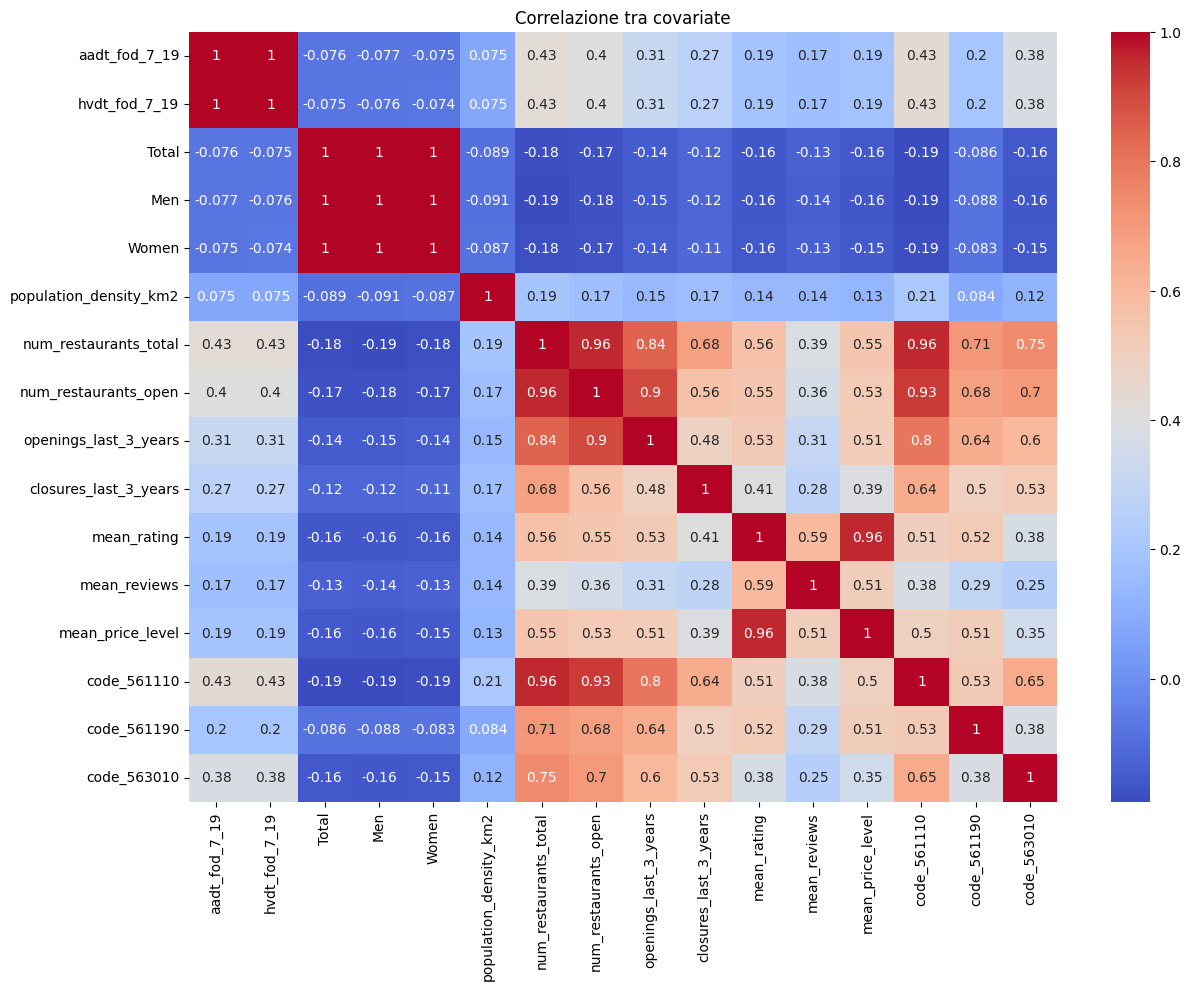

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_cox[columns_for_model].corr(), annot=True, cmap="coolwarm")
plt.title("Correlazione tra covariate")
plt.show()

In [ ]:
columns_for_model = [
    "aadt_fod_7_19",
    "Total",
    "population_density_km2",
    "num_restaurants_open",
    "openings_last_3_years",
    "closures_last_3_years",
    "mean_rating",
    "mean_reviews",
    "mean_price_level",
    "code_561110",
    "code_561190",
    "code_563010",
]

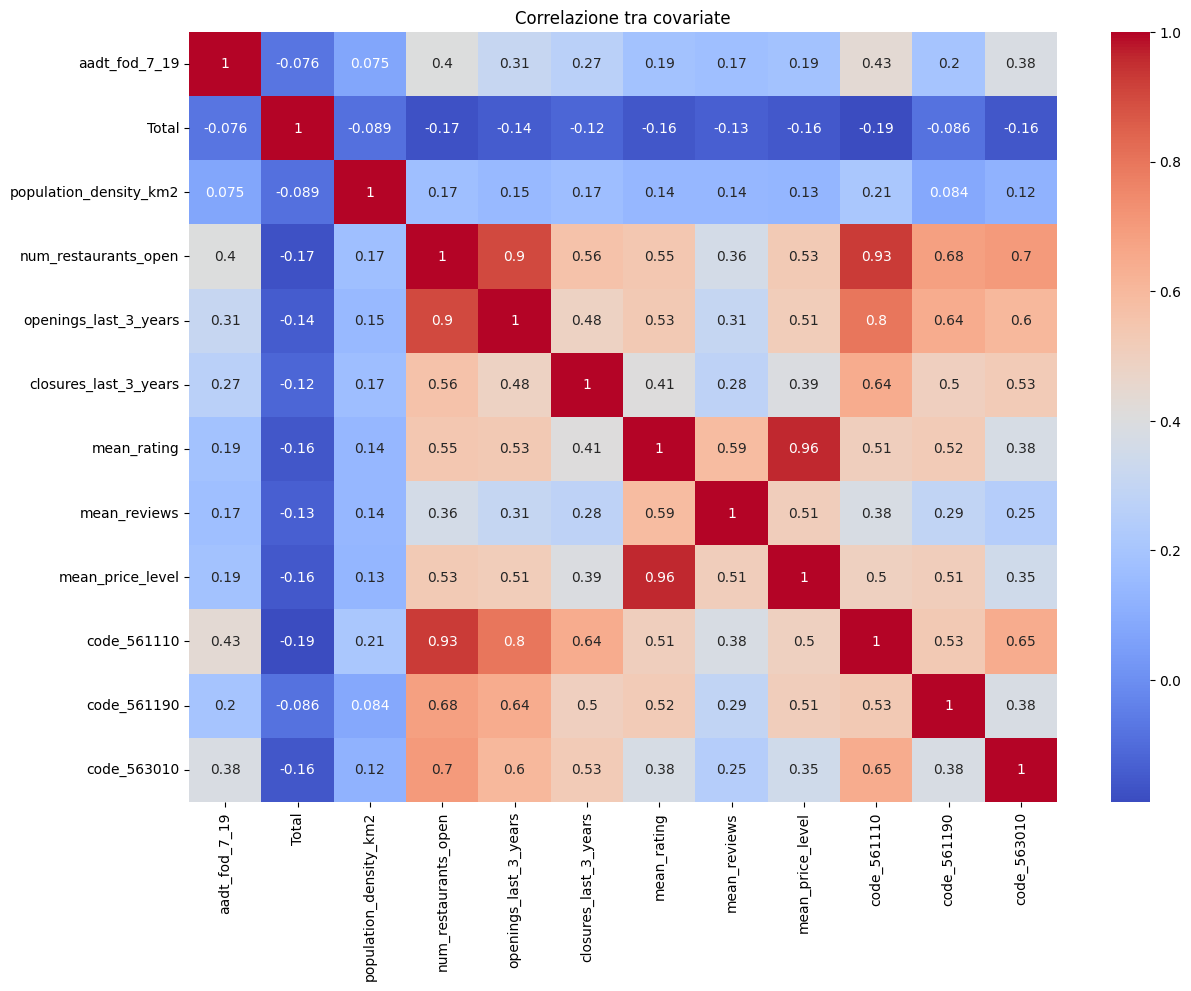

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_cox[columns_for_model].corr(), annot=True, cmap="coolwarm")
plt.title("Correlazione tra covariate")
plt.show()

Now that there is no longer a high collinearity we can **Fit of the Cox Proportional Hazard Model**

In [ ]:
df_cox = df_model[["duration", "event"] + columns_for_model].dropna()
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="duration", event_col="event")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7025 total observations, 5905 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7025
number of events observed = 1120
   partial log-likelihood = -7045.52
         time fit was run = 2025-05-02 20:08:57 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
aadt_fod_7_19           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Total                   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
population_density_km2 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_restaurants_open   -0.74      0.48      0.04           -0.81           -0.66                0.44                0.52
openings_last_3_years   0.82      2.27      0.05            0.73            0.91                2.08                2.48
closures_last_3_years  -0.02      0.98      0.04           -0.09            0.06                0.91                1.06
mean_rating             0.04      1.04      0.09           -0.14            0.21                0.87                1.24
mean_reviews           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
mean_price_level       -0.08      0.92      0.10           -0.28            0.11                0.76                1.12
code_561110             0.24      1.27      0.02            0.20            0.29                1.22                1.33
code_561190             0.33      1.39      0.03            0.27            0.40                1.31                1.49
code_563010             0.17      1.19      0.04            0.10            0.25                1.10                1.28

                        cmp to      z      p  -log2(p)
covariate                                             
aadt_fod_7_19             0.00   1.93   0.05      4.22
Total                     0.00   0.59   0.55      0.85
population_density_km2    0.00  -1.33   0.18      2.44
num_restaurants_open      0.00 -18.38 <0.005    248.13
openings_last_3_years     0.00  18.16 <0.005    242.38
closures_last_3_years     0.00  -0.39   0.70      0.52
mean_rating               0.00   0.44   0.66      0.60
mean_reviews              0.00  -1.55   0.12      3.04
mean_price_level          0.00  -0.83   0.41      1.29
code_561110               0.00  10.34 <0.005     80.78
code_561190               0.00  10.23 <0.005     79.24
code_563010               0.00   4.50 <0.005     17.19
---
Concordance = 0.74
Partial AIC = 14115.04
log-likelihood ratio test = 569.28 on 12 df
-log2(p) of ll-ratio test = 376.77


## **Key Insights from CoxPHFitter**

### **Significant Variables:**

* **Variables with p < 0.05** are statistically significant.
* The following variables have p-values < 0.05, suggesting they **significantly influence survival**:

  `num_restaurants_open` , `openings_last_3_years` , `code_561110` , `code_561190` , `code_563010`

### **Interpretation of Hazard Ratios (exp(coef)):**

* **`code_561110` (Full-service restaurants)**
  **exp(coef) = 1.27**
  This means that for every unit increase in full-service restaurants near a grid point, the hazard of restaurant closure increases by **27%**.

* **`num_restaurants_open`**
  **exp(coef) = 0.48**
  This indicates that more open restaurants near a point decrease the likelihood of a restaurant closing by **52%**.

* **`openings_last_3_years`**
  **exp(coef) = 2.27**
  Areas with more restaurant openings in the last 3 years have a **2.27 times higher risk** of restaurant closure.

### **Non-Significant Variables:**

* Variables with **p > 0.05** are **not statistically significant** in explaining restaurant survival. These include:

  `mean_rating`, `mean_reviews`, `mean_price_level`, `closures_last_3_years`, `aadt_fod_7_19`, `Total`, `population_density_km2`


**Thanks to this analysis we can reemove non-significant variables from the model to simplify it.**

The final variables are gonna be the following:


In [ ]:
columns_for_model = [
    "num_restaurants_open",
    "openings_last_3_years",
    "code_561110",
    "code_561190",
    "code_563010",
]

In [ ]:
df_cox = df_model[["duration", "event"] + columns_for_model].dropna()
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="duration", event_col="event")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7025 total observations, 5905 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7025
number of events observed = 1120
   partial log-likelihood = -7050.13
         time fit was run = 2025-05-02 20:47:11 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
num_restaurants_open  -0.72      0.49      0.04           -0.79           -0.65                0.45                0.52
openings_last_3_years  0.81      2.25      0.04            0.72            0.90                2.06                2.45
code_561110            0.23      1.26      0.02            0.19            0.27                1.21                1.31
code_561190            0.32      1.38      0.03            0.27            0.38                1.31                1.46
code_563010            0.19      1.21      0.03            0.12            0.26                1.13                1.29

                       cmp to      z      p  -log2(p)
covariate                                            
num_restaurants_open     0.00 -19.48 <0.005    278.36
openings_last_3_years    0.00  18.51 <0.005    251.56
code_561110              0.00  11.98 <0.005    107.52
code_561190              0.00  11.27 <0.005     95.43
code_563010              0.00   5.40 <0.005     23.85
---
Concordance = 0.75
Partial AIC = 14110.25
log-likelihood ratio test = 560.07 on 5 df
-log2(p) of ll-ratio test = 392.22

The Concordance Index (C-index) of 0.75 indicates that the model does a good job of discriminating between events and non-events.

### **Survival Score for Each Coordinate**
Now we create a "Survival Score" for each coordinate (latitude, longitude) based on the Cox Proportional Hazards Model. This will be a summary value reflecting the risk of restaurant survival in that area.

Steps:
1. **Predict the hazard ratio (HR) for each coordinate**
CoxPHFitter model to predict the hazard ratio for each row in the dataset, given the features for each coordinate. The hazard ratio will represent the relative risk of restaurant failure (higher value = higher risk).

2. **Invert the hazard ratio**
Since higher hazard ratios represent higher risk (i.e., lower survival), we'll invert it to obtain a Survival Score, where higher values indicate areas with a higher likelihood of survival.

3. **Normalize the Survival Score**
We normalize the survival scores between 0 and 100, to make the data more interpretable.

In [ ]:
# Step 1: predict the hazard ratio for each row using the fitted Cox model
df_model["hazard_ratio"] = cph.predict_partial_hazard(df_model[columns_for_model])

# Step 2: Invert the hazard ratio to create a "Survival Score"
df_model["survival_score"] = 1 / df_model["hazard_ratio"]

# Step 3: Normalize the Survival Score (between 0 and 100)
df_model["survival_score"] = (
    (df_model["survival_score"] - df_model["survival_score"].min())
    / (df_model["survival_score"].max() - df_model["survival_score"].min())
    * 100
)

print(df_model[["latitude", "longitude", "survival_score"]].head())
max_survival_score = df_model["survival_score"].max()
min_survival_score = df_model["survival_score"].min()

max_survival_score, min_survival_score

    latitude  longitude  survival_score
0  55.707340  12.454837        1.279397
1  55.708353  12.454837        1.279397
2  55.709365  12.454837        1.279397
3  55.710377  12.454837        1.279397
4  55.711389  12.454837        1.279397


(100.0, 0.0)

In [ ]:
df_survival_map = df_model[["latitude", "longitude", "survival_score"]].copy()
df_survival_map.to_csv("data/survival_map_data.csv", index=False)
print("Saved survival_map_data.csv")

Saved survival_map_data.csv


### Restaurant Survival Map based of Survival Score
Creation and Storing of an interactive heatmap of Copenaghen Commune with Survival Score.
Green correspondo to high Survival Score, blue correspond to low Survival Score (values from 0 to 100 are used).

In [ ]:
# Load the dataset with survival scores and coordinates
df_survival = pd.read_csv("data/survival_map_data.csv")  # Change to your file path
df_survival = df_survival.dropna(subset=["latitude", "longitude", "survival_score"])

# Initialize the map centered on a general location (adjust as needed)
map_ = folium.Map(location=[55.6761, 12.5683], zoom_start=13)  # Example: Copenhagen

# --- HEATMAP: Survival Scores ---
heat_points = df_survival[["latitude", "longitude", "survival_score"]].values.tolist()

heatmap_layer = folium.FeatureGroup(name="Survival Score Heatmap")
HeatMap(heat_points, radius=15, blur=25, max_zoom=14).add_to(heatmap_layer)
heatmap_layer.add_to(map_)

folium.LayerControl(collapsed=False).add_to(map_)
map_.save("output/interactive_survival_score_map2.html")

## 11th Step - Recommendation System


This recommendation system is designed for someone who wants to open a restaurant in the municipality of Copenhagen and knows the type of business (i.e., the Branchekod) but is unsure where to locate it. By inserting one or more Branchekods corresponding to their restaurant type, the system outputs the top 10 most promising locations based on existing market data.

**Technical Overview**

This is a rule-based, scoring-based recommendation system. It works using a composite score calculated from normalized and weighted features. The method is unsupervised and deterministic.

#### The Recommendation System will be broken down as follows:

1. **Composite Score Calculation and Function Definition**
Define the function to calculate the composite score based on values from the survival analysis and the related recommendation function.

2. **Recommender System Demo**
Show an example of the recommender system for suggesting locations to open a full-service restaurant (code: ['code_561110']).

3. **Top 10 Recommended Location**
Provide a description of the top 10 locations recommended for opening a restaurant.

4. **Visualization on a Map**
Display the top 10 recommended locations on a map for a more user-friendly output.

In [3]:
# lib
import folium
import pandas as pd
from IPython.display import display, HTML

#### Location Recommendation Function: `recommend_locations`

The following code cell defines the function **`recommend_locations`**, that allow us to identify the top 10 optimal locations to open a new restaurant based on the dataset **`df_survival_analysis.csv`** and a list of user-provided Branchekod.

---

#### More in details  
The function filters locations that **have at least one open restaurant for *each* of the specified Branchekod**, ensuring that the recommended areas already support the types of restaurants being considered!!! 

For each eligible location, a **composite score** is computed using a weighted combination of normalized features considered important by the Survival Analysis :

- **Number of open restaurants** (`num_restaurants_open`)  
- **Average survival days** of restaurants (`avg_survival_days`)  
- **Population density** (`population_density_km2`)  
- **Average daily pedestrian traffic** (`aadt_fod_7_19`)  
- **Closures in the last 3 years** (`closures_last_3_years`) – *used as a penalty*  
- **Presence of each specified Branchekod** – contributes up to 40% of the score

Each of these features is normalized and weighted accordingly, with the Branchekod specific contributions scaled based on how many codes were entered.

---

#### Output  
The function ranks all matching locations by their **composite score**, and returns the **top 10** along with the following key indicators:

- Geographic coordinates (latitude and longitude)  
- Postal code  
- Number of open restaurants  
- Average survival days  
- Number of matching restaurants for


In [ ]:
def recommend_locations(codes):
    df = pd.read_csv("data/df_survival_analysis.csv")

    # Filter for locations with at least one restaurant of the specified types
    code_cols = [code for code in codes if code in df.columns]
    if not code_cols:
        raise ValueError("None of the specified codes exist in the dataset")
    has_restaurant_mask = df[code_cols].gt(0).all(axis=1)
    filtered_df = df[has_restaurant_mask].copy()

    # Composite score
    filtered_df["norm_open_restaurants"] = (
        filtered_df["num_restaurants_open"] / filtered_df["num_restaurants_open"].max()
    )
    filtered_df["norm_survival_days"] = (
        filtered_df["avg_survival_days"] / filtered_df["avg_survival_days"].max()
    )
    filtered_df["norm_pop_density"] = (
        filtered_df["population_density_km2"]
        / filtered_df["population_density_km2"].max()
    )
    filtered_df["norm_pedestrian"] = (
        filtered_df["aadt_fod_7_19"] / filtered_df["aadt_fod_7_19"].max()
    )
    filtered_df["norm_closures"] = (
        filtered_df["closures_last_3_years"]
        / filtered_df["closures_last_3_years"].max()
    )

    # Calculate normalized weights for each code based on their relative presence
    for code in code_cols:
        filtered_df[f"norm_{code}"] = filtered_df[code] / filtered_df[code].max()

    code_weight = 0.4
    base_weight = 1 - code_weight

    # Calculate code-specific contribution
    code_contribution = 0
    for code in code_cols:
        norm_col = f"norm_{code}"
        code_contribution += filtered_df[norm_col] * (code_weight / len(code_cols))

    # Final composite score including both base features and code contributions
    filtered_df["composite_score"] = (
        (0.5 * base_weight) * filtered_df["norm_open_restaurants"]
        + (0.4 * base_weight) * filtered_df["norm_survival_days"]
        + (0.05 * base_weight) * filtered_df["norm_pop_density"]
        + (0.05 * base_weight) * filtered_df["norm_pedestrian"]
        - (0.2 * base_weight) * filtered_df["norm_closures"]
        + code_contribution
    )

    # Top 10 locations
    recommendations = filtered_df.sort_values("composite_score", ascending=False).head(
        10
    )

    # Select and rename relevant columns for output
    output_columns = {
        "latitude": "Latitude",
        "longitude": "Longitude",
        "postal_code": "Postal Code",
        "num_restaurants_open": "Number of Open Restaurants",
        "avg_survival_days": "Average Survival Days",
        "composite_score": "Recommendation Score",
    }

    # Add the count of each specified restaurant type
    for code in code_cols:
        output_columns[code] = f"Number of {code} Restaurants"

    print(codes)

    return recommendations[list(output_columns.keys())].rename(columns=output_columns)

Here the user can use the Recommendation System by typing the codes that is planning to have

In [ ]:
# User input
user_input = input(
    "Enter Branchekod separated by commas (e.g. code_561110, code_563010): "
)
codes = [code.strip() for code in user_input.split(",")]
recommendations = recommend_locations(codes)

['code_561110']


The following code is going to show the recommended location on a maps and also more detailed informations for each location.

Tried in advance with the following input: codes = ['code_561110']

In [ ]:
print("\nTop 10 recommended locations:")

# Create the map centered around the average coordinates of the recommendations
map_center = [recommendations["Latitude"].mean(), recommendations["Longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# Add markers for each recommended location
for idx, row in recommendations.iterrows():
    popup_text = (
        f"<b>Postal Code:</b> {int(row['Postal Code'])}<br>"
        f"<b>Open Restaurants:</b> {row['Number of Open Restaurants']}<br>"
        f"<b>Avg Survival Days:</b> {int(row['Average Survival Days'])}<br>"
        f"<b>Score:</b> {row['Recommendation Score']:.3f}"
    )
    for code in codes:
        col_name = f"Number of {code} Restaurants"
        if col_name in row:
            popup_text += f"<br><b>{code}:</b> {row[col_name]}"

    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color="blue", icon="cutlery", prefix="fa"),
    ).add_to(m)

# Define desired map size
map_width = "700px"
map_height = "500px"

# Display map with specified dimensions
m_html = m._repr_html_()
display(HTML(f'<div style="width:{map_width}; height:{map_height};">{m_html}</div>'))


# table for best coordinates
summary_data = []

for idx, row in recommendations.iterrows():
    entry = {
        "Postal Code": int(row["Postal Code"]),
        "Latitude": f"{row['Latitude']:.6f}",
        "Longitude": f"{row['Longitude']:.6f}",
        "Open Restaurants": row["Number of Open Restaurants"],
        "Avg Survival Days": int(row["Average Survival Days"]),
        "Score": round(row["Recommendation Score"], 3),
    }

    for code in codes:
        col = f"Number of {code} Restaurants"
        if col in row:
            entry[code] = row[col]

    summary_data.append(entry)


summary_df = pd.DataFrame(summary_data)


display(summary_df)


Top 10 recommended locations:


,Postal Code,Latitude,Longitude,Open Restaurants,Avg Survival Days,Score,code_561110
0,1570,55.673921,12.564431,27.0,1998,0.742,28.0
1,1577,55.673921,12.566228,25.0,1932,0.689,26.0
2,1620,55.674935,12.566228,20.0,1989,0.601,24.0
3,1620,55.674935,12.564431,17.0,2218,0.522,20.0
4,1457,55.677974,12.571618,22.0,2695,0.504,15.0
5,1253,55.680000,12.591381,15.0,1724,0.495,23.0
6,1159,55.678987,12.573414,21.0,1517,0.493,15.0
7,1450,55.677974,12.573414,21.0,1733,0.483,15.0
8,1157,55.678987,12.575211,14.0,2804,0.472,18.0
9,1173,55.682026,12.573414,16.0,1551,0.451,18.0


## Conclusion

In conclusion, this project proved to be extremely interesting and stimulating—from the very beginning, when we set out to find a topic that matched our interests, to the end, when we could finally see our final product and the quality of the work we had achieved.


**Data Scraping**

The data scraping phase was one of the main challenges, but also one of the most rewarding aspects of the work. We deliberately chose not to use pre-packaged datasets (such as those available on Kaggle), but to build an original dataset from scratch, which best reflected the reality we wanted to analyse. This approach challenged us both technically and conceptually, but we are very happy with the uniqueness of our dataset.

**Survival Analysis**

Along the way, we found ourselves several times having to reformulate our research question and rethink the best way to apply survival analysis to the collected data. The results that emerged were surprising: while one usually tends to think that population density, price level or quality of reviews are the main indicators of a restaurant's longevity, our analysis showed that these factors are not as decisive as expected.

**Recommendation System**

Finally, we believe that the developed interactive recommendation system, which also allows you to view recommended areas for a new opening, is a practical and very useful piece of equipment. It could prove invaluable for those who want to open a new restaurant and want to base their choices on solid data and in-depth analysis.